In [1]:
import pandas as pd

# Load all CSV files from data folder
dataset = 'yellow_tripdata_2016-02.csv'
df = pd.read_csv(dataset)


In [2]:
print("Shape:", df.shape)
df.head()

Shape: (11382049, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-02-25 17:24:20,2016-02-25 17:27:20,2,0.70,-73.947250,40.763771,1,N,-73.992012,40.735390,2,5.0,0.0,0.5,0.0,0.0,0.3,5.8
1,2,2016-02-25 23:10:50,2016-02-25 23:31:50,2,5.52,-73.983017,40.750992,1,N,-73.988586,40.758839,2,20.0,0.5,0.5,0.0,0.0,0.3,21.3
2,2,2016-02-01 00:00:01,2016-02-01 00:10:52,6,1.99,-73.992340,40.758202,1,N,-73.964355,40.757977,1,9.5,0.5,0.5,0.7,0.0,0.3,11.5
3,1,2016-02-01 00:00:04,2016-02-01 00:05:16,1,1.50,-73.981453,40.749722,1,N,-73.982323,40.763985,2,6.5,0.5,0.5,0.0,0.0,0.3,7.8
4,2,2016-02-01 00:00:05,2016-02-01 00:20:59,1,5.60,-74.000603,40.729755,1,N,-73.951324,40.669834,1,20.0,0.5,0.5,4.0,0.0,0.3,25.3


### Feature Correlation Analysis

To better understand relationships among key variables, we compute a correlation matrix over a subset of the dataset (up to 500k rows for performance).

Before generating the heatmap, we engineer several features:

- **trip_duration** (minutes)
- **hour** of pickup
- **day_of_week**
- **speed_mph** computed from distance and duration

The heatmap helps reveal:
- Which features strongly influence fare amount
- Multicollinearity between predictors
- Temporal or behavioral patterns
- Potential issues such as redundant or weak predictors

This step guides feature selection and provides intuition about model behavior.


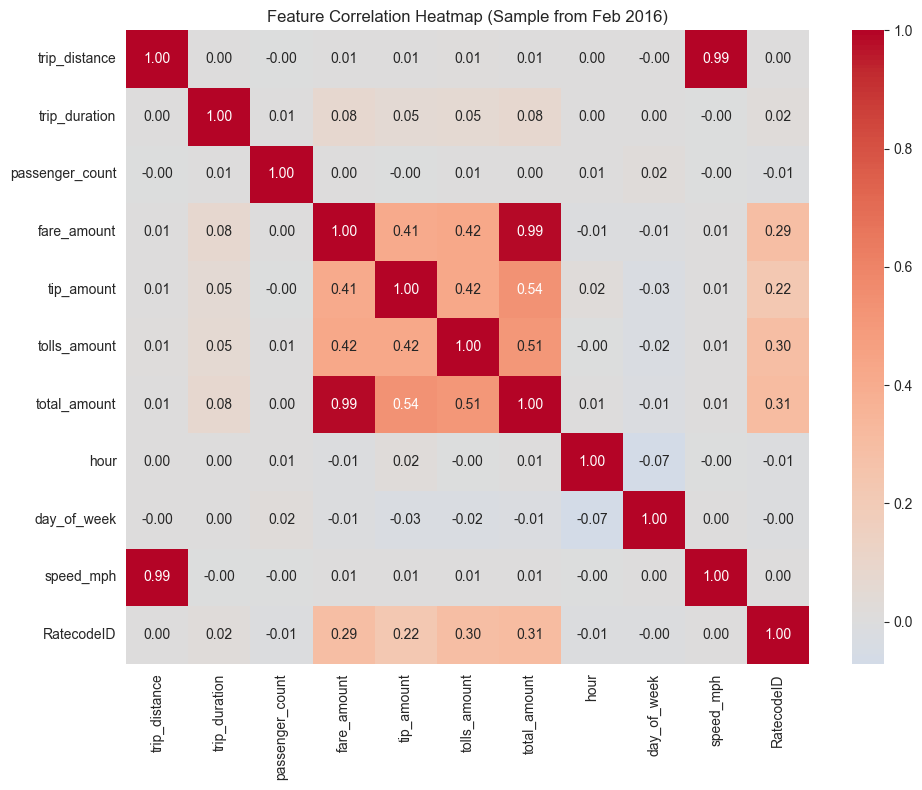

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Work on a copy for feature creation
corr_df = df.copy()

# Datetime features
corr_df["pickup_datetime"] = pd.to_datetime(corr_df["tpep_pickup_datetime"])
corr_df["dropoff_datetime"] = pd.to_datetime(corr_df["tpep_dropoff_datetime"])

corr_df["trip_duration"] = (
    (corr_df["dropoff_datetime"] - corr_df["pickup_datetime"])
    .dt.total_seconds() / 60  # minutes
)

corr_df["hour"] = corr_df["pickup_datetime"].dt.hour
corr_df["day_of_week"] = corr_df["pickup_datetime"].dt.dayofweek

# Speed in miles per hour (trip_distance is in miles)
corr_df["speed_mph"] = corr_df["trip_distance"] / (corr_df["trip_duration"] / 60)

# Select features for correlation analysis
features = [
    "trip_distance",
    "trip_duration",
    "passenger_count",
    "fare_amount",
    "tip_amount",
    "tolls_amount",
    "total_amount",
    "hour",
    "day_of_week",
    "speed_mph",
    "RatecodeID",
]

# Drop rows with missing values in these columns
corr_df = corr_df[features].dropna()

# Use a sample for performance on the 1.78 GB file
if len(corr_df) > 500_000:
    corr_sample = corr_df.sample(500_000, random_state=42)
else:
    corr_sample = corr_df

corr_matrix = corr_sample.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Feature Correlation Heatmap (Sample from Feb 2016)")
plt.tight_layout()
plt.show()


### Exploratory Data Analysis (Raw Dataset)

Before performing any cleaning or feature engineering, we first explore the raw
NYC Yellow Taxi dataset to understand the distribution of key variables and
identify early data quality issues.

This EDA block:

- converts pickup/dropoff times into useful temporal features (hour, weekday),
- computes basic trip characteristics such as distance, duration, and passenger count,
- visualises distributions of fares, distances, durations, and passenger counts,
- analyses temporal fare patterns (hourly and weekly),
- provides summary statistics and simple insights,
- applies **99th-percentile filtering only for visualization purposes** to prevent
  extreme outliers from dominating the plots.

These plots help us understand the overall structure of the dataset and guide
subsequent cleaning and feature-engineering decisions.


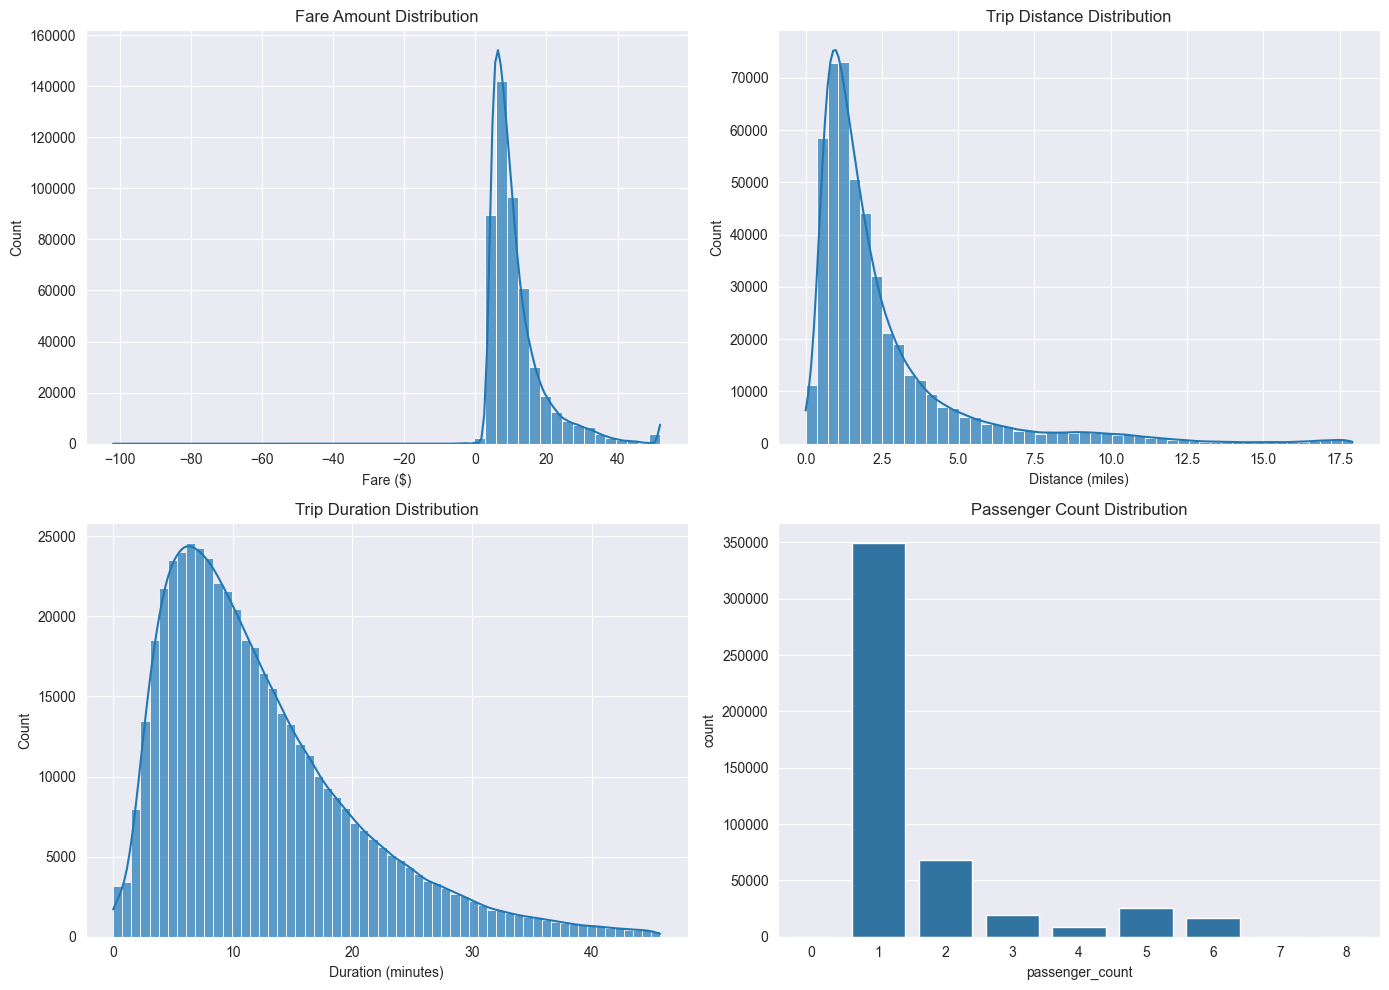

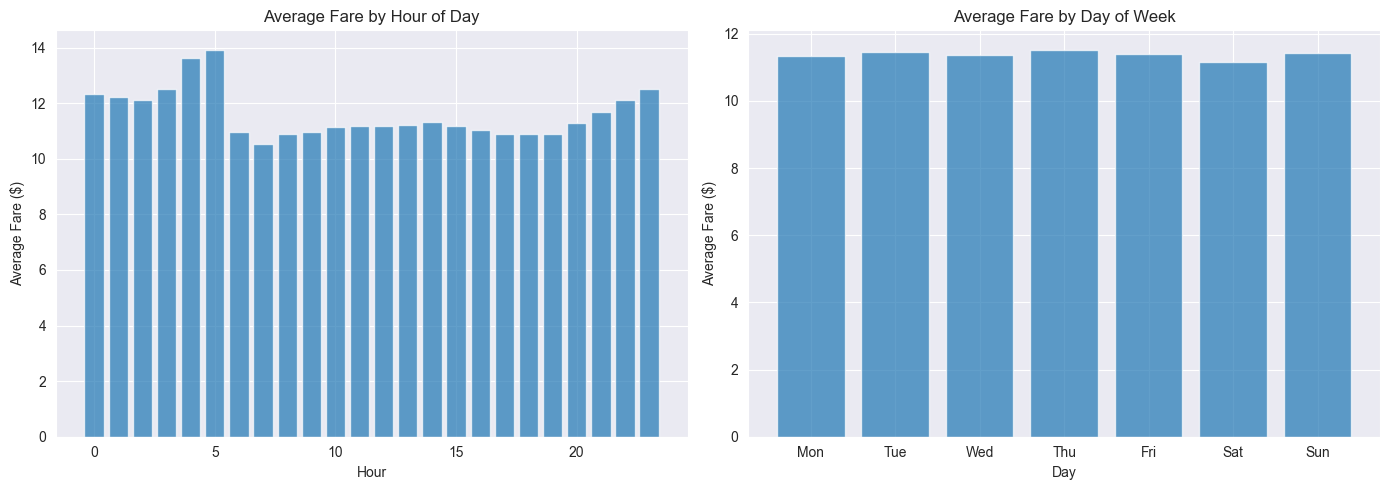


ENHANCED STATISTICAL SUMMARY
       fare_amount  trip_distance  trip_duration  passenger_count
count    487494.00      487494.00      487494.00        487494.00
mean         11.38           2.52          12.31             1.65
std           7.90           2.67           8.14             1.31
min        -102.00           0.00           0.00             0.00
25%           6.50           0.98           6.27             1.00
50%           9.00           1.60          10.35             1.00
75%          13.50           2.90          16.35             2.00
max          52.00          17.93          45.73             8.00

KEY INSIGHTS:
• Peak hour (highest avg fare): 5:00 -> $13.93
• Busiest day: Thu -> $11.53 avg fare
• Most common passenger count: 1


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Make sure we have datetime + duration + hour + weekday
viz_df = df.copy()
viz_df["pickup_datetime"] = pd.to_datetime(viz_df["tpep_pickup_datetime"])
viz_df["dropoff_datetime"] = pd.to_datetime(viz_df["tpep_dropoff_datetime"])

viz_df["trip_duration"] = (
    (viz_df["dropoff_datetime"] - viz_df["pickup_datetime"])
    .dt.total_seconds() / 60
)
viz_df["hour"] = viz_df["pickup_datetime"].dt.hour
viz_df["day_of_week"] = viz_df["pickup_datetime"].dt.dayofweek

viz_df = viz_df[
    ["fare_amount", "trip_distance", "trip_duration",
     "passenger_count", "hour", "day_of_week"]
].dropna()

# Sample for speed & plotting
if len(viz_df) > 500_000:
    viz_df = viz_df.sample(500_000, random_state=42)

# Helper for nicer plots (filter extreme outliers)
def filter_for_viz(df_in, percentile=99):
    numeric_cols = ["fare_amount", "trip_distance", "trip_duration"]
    df_v = df_in.copy()

    for col in numeric_cols:
        if col in df_v.columns:
            q = df_v[col].quantile(percentile / 100)
            df_v = df_v[df_v[col] <= q]

    return df_v

viz_data = filter_for_viz(viz_df)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Fare distribution
sns.histplot(viz_data["fare_amount"], bins=50, kde=True,
             ax=axes[0, 0], alpha=0.7)
axes[0, 0].set_title("Fare Amount Distribution")
axes[0, 0].set_xlabel("Fare ($)")

# Trip distance
sns.histplot(viz_data["trip_distance"], bins=50, kde=True,
             ax=axes[0, 1], alpha=0.7)
axes[0, 1].set_title("Trip Distance Distribution")
axes[0, 1].set_xlabel("Distance (miles)")

# Trip duration
sns.histplot(viz_data["trip_duration"], bins=60, kde=True,
             ax=axes[1, 0], alpha=0.7)
axes[1, 0].set_title("Trip Duration Distribution")
axes[1, 0].set_xlabel("Duration (minutes)")

# Passenger count
sns.countplot(
    x="passenger_count", data=viz_data, ax=axes[1, 1]
)
axes[1, 1].set_title("Passenger Count Distribution")

plt.tight_layout()
plt.show()

# Hourly and weekly patterns
hourly_avg = viz_data.groupby("hour")["fare_amount"].mean()
weekly_avg = viz_data.groupby("day_of_week")["fare_amount"].mean()
day_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.bar(hourly_avg.index, hourly_avg.values, alpha=0.7)
plt.title("Average Fare by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Average Fare ($)")

plt.subplot(1, 2, 2)
plt.bar(range(7), weekly_avg.values, alpha=0.7)
plt.title("Average Fare by Day of Week")
plt.xlabel("Day")
plt.ylabel("Average Fare ($)")
plt.xticks(range(7), day_names)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "=" * 60)
print("ENHANCED STATISTICAL SUMMARY")
print("=" * 60)

summary_stats = viz_data[["fare_amount", "trip_distance",
                          "trip_duration", "passenger_count"]].describe()
print(summary_stats.round(2))

print("\nKEY INSIGHTS:")
print(f"• Peak hour (highest avg fare): {hourly_avg.idxmax()}:00 -> ${hourly_avg.max():.2f}")
print(f"• Busiest day: {day_names[weekly_avg.idxmax()]} -> ${weekly_avg.max():.2f} avg fare")
print(f"• Most common passenger count: {viz_data['passenger_count'].mode()[0]}")


### Data Cleaning

We apply light but essential cleaning to remove obviously invalid trips.
This step is intentionally minimal because CatBoost does not require heavy preprocessing.

Cleaning steps include:
- removing duplicates
- dropping rows missing critical information (fare, distance, coordinates)
- removing negative or zero fares and distances
- filtering latitude/longitude to the NYC region to eliminate corrupted GPS records

These steps ensure reliable features while preserving the overall distribution of the dataset.


In [5]:
# Start with a fresh working copy
data = df.copy()

print("Initial shape:", data.shape)

# Remove duplicates (not many, but good practice)
data = data.drop_duplicates()

# Remove rows missing critical columns
critical_cols = [
    "pickup_longitude", "pickup_latitude",
    "dropoff_longitude", "dropoff_latitude",
    "trip_distance", "fare_amount"
]

data = data.dropna(subset=critical_cols)

print("After removing missing critical values:", data.shape)

# Remove impossible or obviously bad fare/distance values
data = data[data["fare_amount"] > 0]
data = data[data["trip_distance"] > 0]

print("After basic fare/distance cleaning:", data.shape)

# Filter to NYC bounding box (removes broken GPS points)
data = data[
    (data["pickup_longitude"] >= -74.3) & (data["pickup_longitude"] <= -73.7) &
    (data["pickup_latitude"] >= 40.5) & (data["pickup_latitude"] <= 40.9) &
    (data["dropoff_longitude"] >= -74.3) & (data["dropoff_longitude"] <= -73.7) &
    (data["dropoff_latitude"] >= 40.5) & (data["dropoff_latitude"] <= 40.9)
]

print("After GPS coordinate filtering:", data.shape)


Initial shape: (11382049, 19)
After removing missing critical values: (11382048, 19)
After basic fare/distance cleaning: (11309139, 19)
After GPS coordinate filtering: (11129680, 19)


### Feature Engineering

We enrich the dataset with additional, more informative features that help the model learn patterns:

- Convert pickup and dropoff times to proper `datetime`
- Derive **temporal features**:
  - `pickup_hour` – hour of the day (captures rush hours)
  - `pickup_dayofweek` – day of the week (weekday vs weekend)
  - `pickup_month` – monthly effect
  - `is_weekend` – binary flag for Saturday/Sunday
- Compute **trip duration** in minutes
- Compute **Haversine distance** in kilometers from pickup to dropoff coordinates

These engineered features are strong predictors of fare amount and are used as inputs to our CatBoost model.


In [6]:
import numpy as np

# --- Datetime features ---
data["pickup_datetime"] = pd.to_datetime(data["tpep_pickup_datetime"])
data["dropoff_datetime"] = pd.to_datetime(data["tpep_dropoff_datetime"])

# Trip duration in minutes
data["trip_duration_min"] = (
    (data["dropoff_datetime"] - data["pickup_datetime"])
    .dt.total_seconds() / 60
)

# Remove clearly broken durations
data = data[(data["trip_duration_min"] > 0) & (data["trip_duration_min"] < 300)]

# Time-based features
data["pickup_hour"] = data["pickup_datetime"].dt.hour
data["pickup_dayofweek"] = data["pickup_datetime"].dt.dayofweek  # 0 = Mon
data["pickup_month"] = data["pickup_datetime"].dt.month
data["is_weekend"] = data["pickup_dayofweek"].isin([5, 6]).astype(int)

# --- Haversine distance (strong feature for fare prediction) ---
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Compute the great-circle distance between two points on Earth (km).
    Input in degrees.
    """
    R = 6371.0  # Earth radius in km

    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = (
        np.sin(dlat / 2.0) ** 2
        + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0) ** 2
    )
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

data["distance_km_haversine"] = haversine_distance(
    data["pickup_latitude"], data["pickup_longitude"],
    data["dropoff_latitude"], data["dropoff_longitude"]
)

# Filter out clearly broken distances
data = data[(data["distance_km_haversine"] > 0) & (data["distance_km_haversine"] < 100)]

print("After feature engineering:", data.shape)
data[[
    "fare_amount", "trip_distance", "distance_km_haversine",
    "trip_duration_min", "pickup_hour", "pickup_dayofweek",
    "pickup_month", "is_weekend"
]].head()


After feature engineering: (11079776, 27)


,fare_amount,trip_distance,distance_km_haversine,trip_duration_min,pickup_hour,pickup_dayofweek,pickup_month,is_weekend
0,5.0,0.70,4.917022,3.00,17,3,2,0
1,20.0,5.52,0.990646,21.00,23,3,2,0
2,9.5,1.99,2.357197,10.85,0,0,2,0
3,6.5,1.50,1.587681,5.20,0,0,2,0
4,20.0,5.60,7.851890,20.90,0,0,2,0


## Removing Extreme Outliers

Before training and visualization, we remove a small fraction of extreme outliers.
NYC taxi data contains rare but very large values (e.g., $1000+ fares, 200+ mile trips) caused by GPS errors, incorrect meter readings, or data-entry issues.

We apply percentile-based filtering (e.g., the 99th percentile) **only for visualization or optional model training**.
This preserves the natural distribution while preventing extreme values from dominating plots and metrics.

This step improves:
- clarity of visualizations,
- stability of summary statistics,
- interpretability of feature relationships.

The underlying cleaned dataset (after basic cleaning) remains untouched — outlier filtering is **only used on samples for EDA and plots**.



In [12]:
### Outlier Removal

print("Before outlier removal:", data.shape)

# Remove impossible durations
data = data[(data["trip_duration_min"] > 0) & (data["trip_duration_min"] < 90)]

# Remove impossible Haversine distances
data = data[(data["distance_km_haversine"] > 0) & (data["distance_km_haversine"] < 50)]  # NYC max

# Remove outlier trip_distance
data = data[(data["trip_distance"] > 0) & (data["trip_distance"] < 40)]

# Remove fare outliers
data = data[(data["fare_amount"] > 0) & (data["fare_amount"] < 1000)]  # NYC fares rarely > $100

print("After outlier removal:", data.shape)


Before outlier removal: (11078577, 30)
After outlier removal: (11076145, 30)


## Exploratory Data Analysis (EDA) on Cleaned Taxi Trips

To understand the distribution and behavior of the key variables in the NYC taxi dataset, we perform an extensive exploratory data analysis (EDA).

Because the full dataset is extremely large, we:
- sample a subset of 200,000 rows for visualization,
- ensure all required engineered features exist (duration, hour, weekday, etc.),
- apply mild outlier filtering (99th percentile) *only for visualization*.

The following visualizations provide insight into:
- fare, distance, and duration distributions,
- hourly and weekly demand patterns,
- geographic pickup density,
- relationships between features (e.g., distance ↔ fare, duration ↔ fare),
- passenger count distribution.

These plots help verify assumptions, detect anomalies, and guide feature engineering and modeling decisions.


Sampled 200000 rows from cleaned data
Filtered from 200000 to 195267 records (removed extreme outliers)


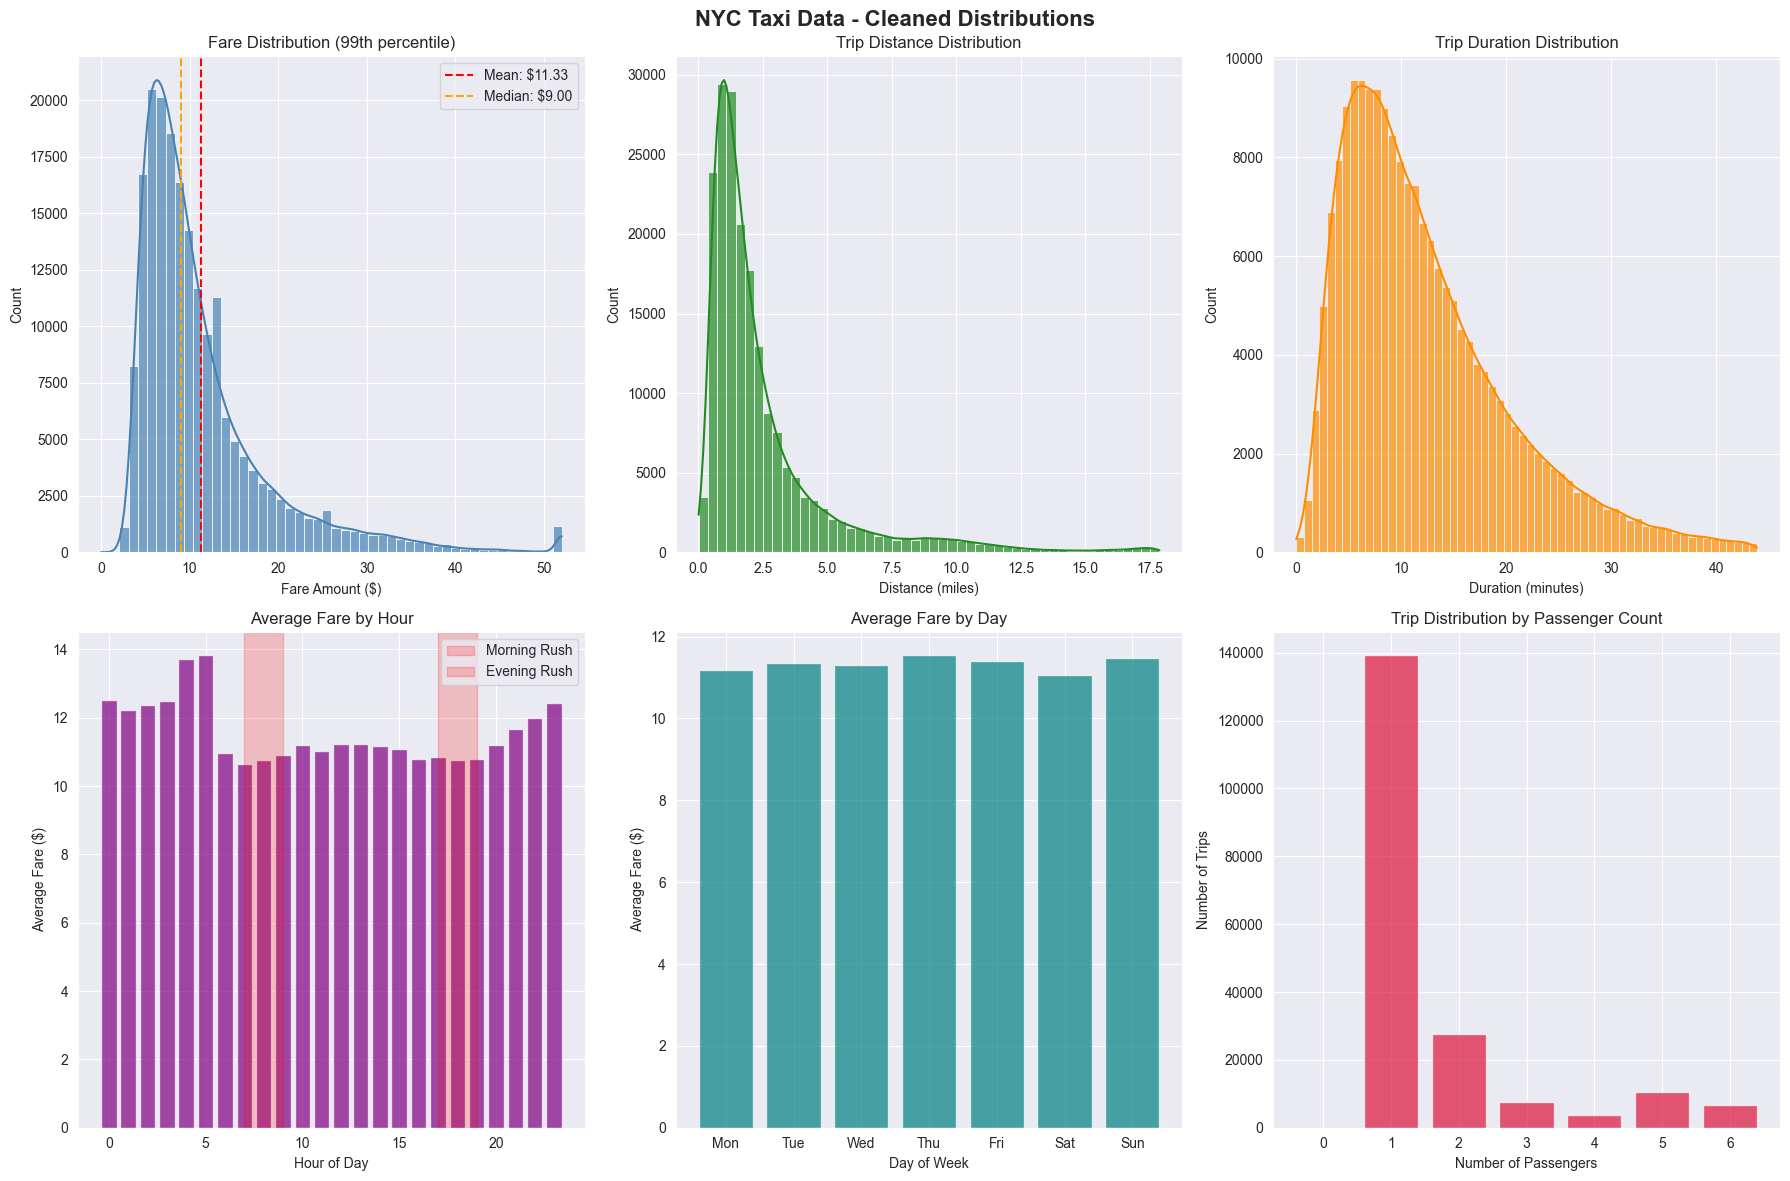

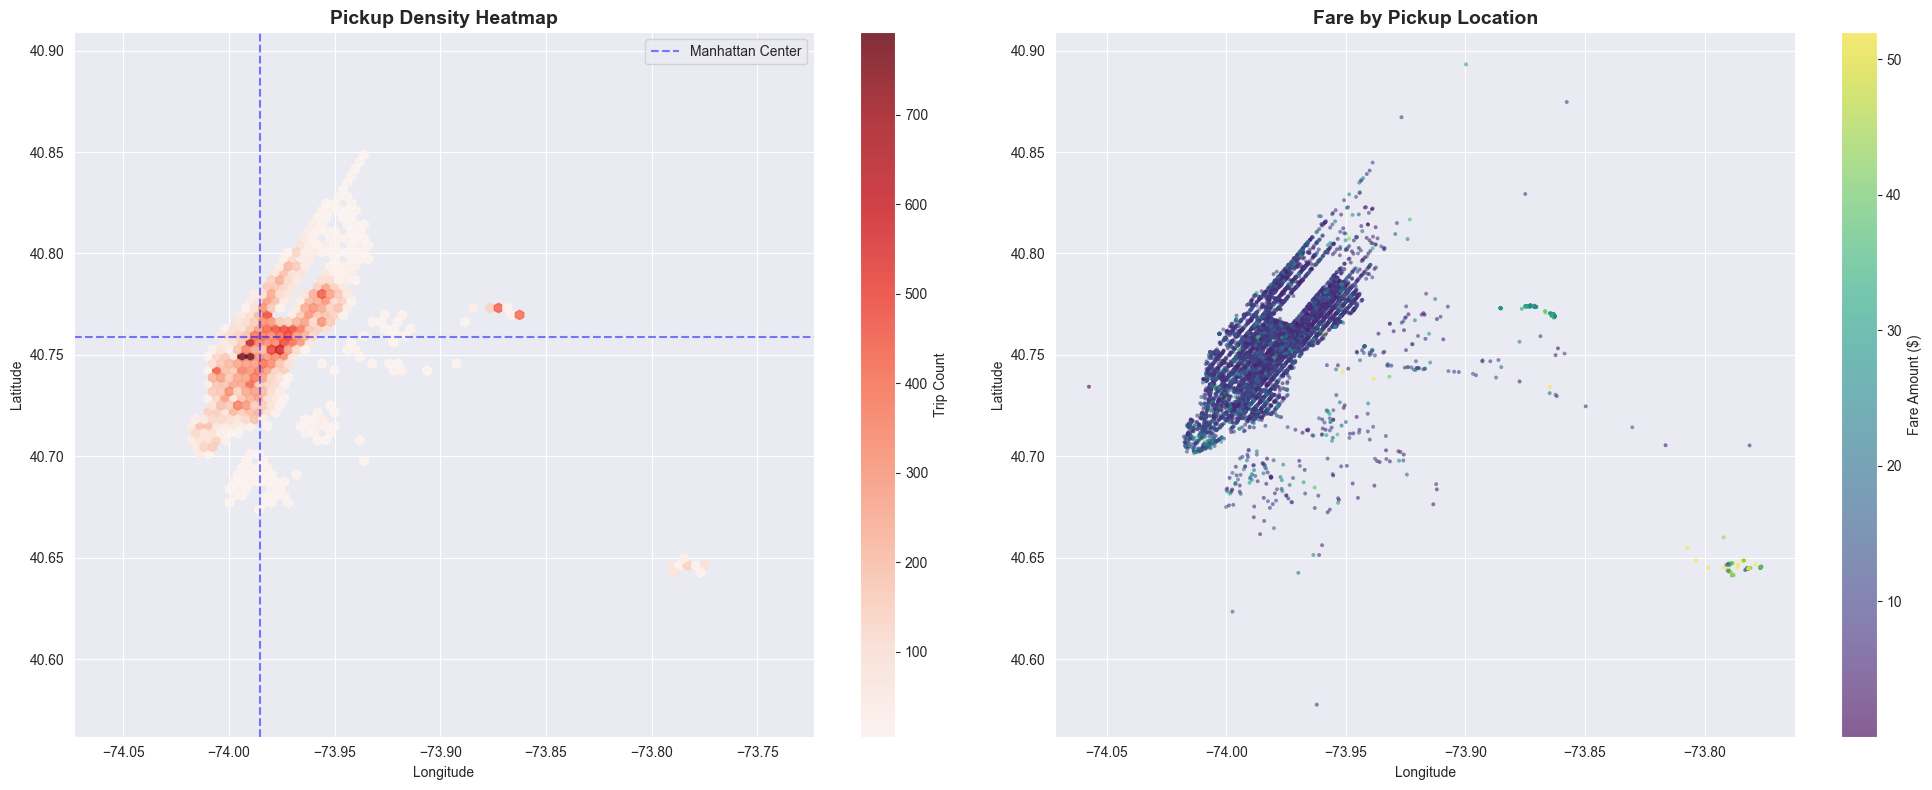

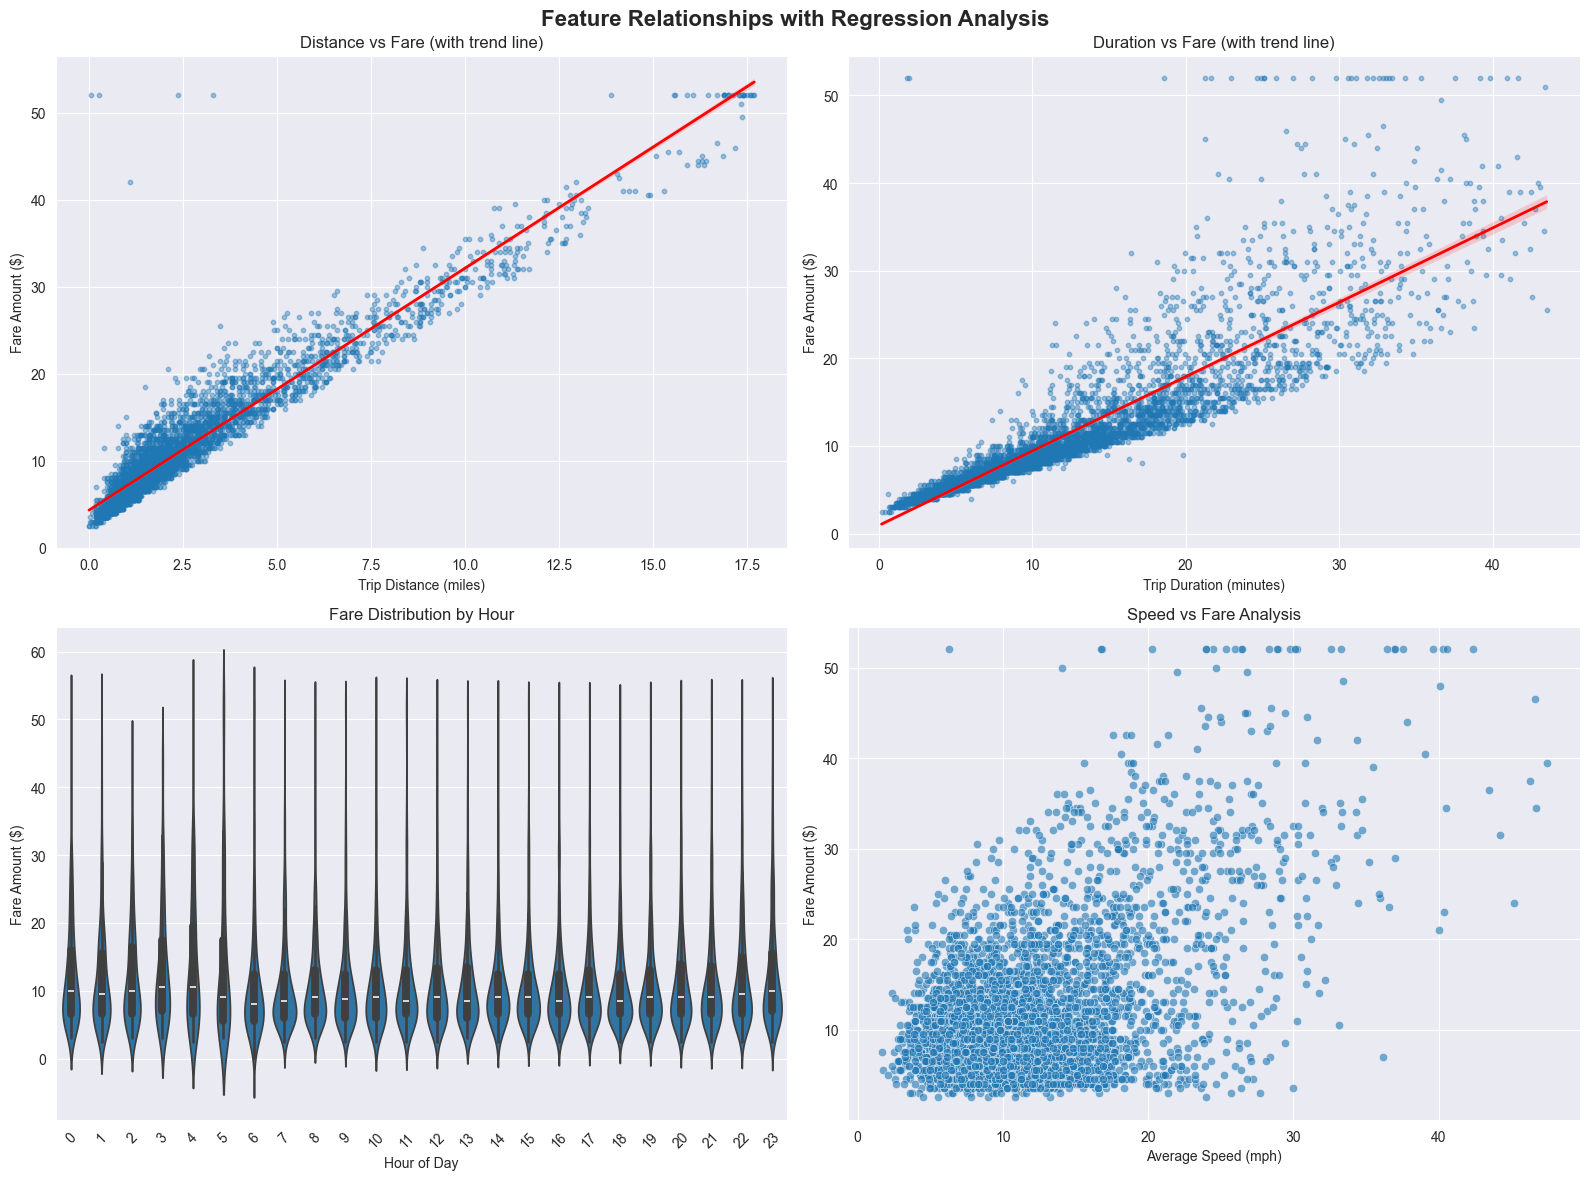


ENHANCED STATISTICAL SUMMARY
       fare_amount  trip_distance  trip_duration  passenger_count
count    195267.00      195267.00      195267.00        195267.00
mean         11.33           2.52          12.32             1.66
std           7.68           2.63           8.01             1.32
min           0.01           0.01           0.02             0.00
25%           6.50           1.00           6.33             1.00
50%           9.00           1.60          10.37             1.00
75%          13.50           2.90          16.32             2.00
max          52.00          17.88          43.85             6.00

KEY INSIGHTS:
• Peak hours: 5:00 ($13.82 avg fare)
• Busiest day: Thu ($11.54 avg fare)
• Most common passenger count: 1


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure needed engineered columns exist (idempotent if already created)
if "pickup_datetime" not in data.columns:
    data["pickup_datetime"] = pd.to_datetime(data["tpep_pickup_datetime"])
if "trip_duration" not in data.columns:
    data["dropoff_datetime"] = pd.to_datetime(data["tpep_dropoff_datetime"])
    data["trip_duration"] = (
        (data["dropoff_datetime"] - data["pickup_datetime"])
        .dt.total_seconds() / 60
    )
if "hour" not in data.columns:
    data["hour"] = data["pickup_datetime"].dt.hour
if "day_of_week" not in data.columns:
    data["day_of_week"] = data["pickup_datetime"].dt.dayofweek

# Sample from cleaned data for plotting (huge dataset otherwise)
data_sample = data.sample(200_000, random_state=42)
print(f"Sampled {len(data_sample)} rows from cleaned data")

# Apply outlier filtering for better visualization
def filter_for_viz(df, percentile=99):
    """Filter data to remove extreme outliers for visualization"""
    numeric_cols = ["fare_amount", "trip_distance", "trip_duration"]
    filtered_df = df.copy()

    for col in numeric_cols:
        if col in filtered_df.columns:
            q99 = filtered_df[col].quantile(percentile / 100)
            filtered_df = filtered_df[filtered_df[col] <= q99]

    return filtered_df

viz_data = filter_for_viz(data_sample, 99)
print(f"Filtered from {len(data_sample)} to {len(viz_data)} records (removed extreme outliers)")

# 1. IMPROVED: Multi-panel with better scaling
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("NYC Taxi Data - Cleaned Distributions", fontsize=16, fontweight="bold")

# Fare distribution with statistics
sns.histplot(viz_data["fare_amount"], bins=50, kde=True, ax=axes[0, 0],
             color="steelblue", alpha=0.7)
axes[0, 0].axvline(viz_data["fare_amount"].mean(), color="red",
                   linestyle="--", label=f'Mean: ${viz_data["fare_amount"].mean():.2f}')
axes[0, 0].axvline(viz_data["fare_amount"].median(), color="orange",
                   linestyle="--", label=f'Median: ${viz_data["fare_amount"].median():.2f}')
axes[0, 0].set_title("Fare Distribution (99th percentile)")
axes[0, 0].set_xlabel("Fare Amount ($)")
axes[0, 0].legend()

# Distance
sns.histplot(viz_data["trip_distance"], bins=50, kde=True, ax=axes[0, 1],
             color="forestgreen", alpha=0.7)
axes[0, 1].set_title("Trip Distance Distribution")
axes[0, 1].set_xlabel("Distance (miles)")

# Duration
sns.histplot(viz_data["trip_duration"], bins=60, kde=True, ax=axes[0, 2],
             color="darkorange", alpha=0.7)
axes[0, 2].set_title("Trip Duration Distribution")
axes[0, 2].set_xlabel("Duration (minutes)")

# Hourly patterns with annotations
hourly_avg = viz_data.groupby("hour")["fare_amount"].mean()
axes[1, 0].bar(hourly_avg.index, hourly_avg.values, color="purple", alpha=0.7)
axes[1, 0].set_title("Average Fare by Hour")
axes[1, 0].set_xlabel("Hour of Day")
axes[1, 0].set_ylabel("Average Fare ($)")
axes[1, 0].axvspan(7, 9, alpha=0.2, color="red", label="Morning Rush")
axes[1, 0].axvspan(17, 19, alpha=0.2, color="red", label="Evening Rush")
axes[1, 0].legend()

# Weekly patterns
weekly_avg = viz_data.groupby("day_of_week")["fare_amount"].mean()
day_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
axes[1, 1].bar(range(7), weekly_avg.values, color="teal", alpha=0.7)
axes[1, 1].set_title("Average Fare by Day")
axes[1, 1].set_xlabel("Day of Week")
axes[1, 1].set_ylabel("Average Fare ($)")
axes[1, 1].set_xticks(range(7))
axes[1, 1].set_xticklabels(day_names)

# Passenger count with percentages
passenger_counts = viz_data["passenger_count"].value_counts().sort_index()
axes[1, 2].bar(passenger_counts.index, passenger_counts.values,
               color="crimson", alpha=0.7)
axes[1, 2].set_title("Trip Distribution by Passenger Count")
axes[1, 2].set_xlabel("Number of Passengers")
axes[1, 2].set_ylabel("Number of Trips")

plt.tight_layout()
plt.show()

# 2. Geographic analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

geo_sample = viz_data.sample(50_000, random_state=42)
hb = ax1.hexbin(
    geo_sample["pickup_longitude"],
    geo_sample["pickup_latitude"],
    gridsize=80, cmap="Reds", mincnt=5, alpha=0.8,
)
ax1.set_title("Pickup Density Heatmap", fontsize=14, fontweight="bold")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
plt.colorbar(hb, ax=ax1, label="Trip Count")
ax1.axhline(y=40.7589, color="blue", linestyle="--", alpha=0.5, label="Manhattan Center")
ax1.axvline(x=-73.9851, color="blue", linestyle="--", alpha=0.5)
ax1.legend()

fare_sample = viz_data.sample(10_000, random_state=42)
scatter = ax2.scatter(
    fare_sample["pickup_longitude"], fare_sample["pickup_latitude"],
    c=fare_sample["fare_amount"], cmap="viridis",
    alpha=0.6, s=8, edgecolors="none",
)
ax2.set_title("Fare by Pickup Location", fontsize=14, fontweight="bold")
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
plt.colorbar(scatter, ax=ax2, label="Fare Amount ($)")

plt.tight_layout()
plt.show()

# 3. Relationships with regression lines
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Feature Relationships with Regression Analysis", fontsize=16, fontweight="bold")

sample_reg = viz_data.sample(5_000, random_state=42)

# Distance vs Fare
axes[0, 0].scatter(sample_reg["trip_distance"], sample_reg["fare_amount"],
                   alpha=0.4, s=10)
sns.regplot(
    data=sample_reg, x="trip_distance", y="fare_amount", ax=axes[0, 0],
    scatter=False, color="red", line_kws={"linewidth": 2}
)
axes[0, 0].set_title("Distance vs Fare (with trend line)")
axes[0, 0].set_xlabel("Trip Distance (miles)")
axes[0, 0].set_ylabel("Fare Amount ($)")

# Duration vs Fare
axes[0, 1].scatter(sample_reg["trip_duration"], sample_reg["fare_amount"],
                   alpha=0.4, s=10)
sns.regplot(
    data=sample_reg, x="trip_duration", y="fare_amount", ax=axes[0, 1],
    scatter=False, color="red", line_kws={"linewidth": 2}
)
axes[0, 1].set_title("Duration vs Fare (with trend line)")
axes[0, 1].set_xlabel("Trip Duration (minutes)")
axes[0, 1].set_ylabel("Fare Amount ($)")

# Hourly fare distribution (violin plot)
sns.violinplot(
    data=viz_data.sample(20_000, random_state=42),
    x="hour", y="fare_amount", ax=axes[1, 0]
)
axes[1, 0].set_title("Fare Distribution by Hour")
axes[1, 0].set_xlabel("Hour of Day")
axes[1, 0].set_ylabel("Fare Amount ($)")
axes[1, 0].tick_params(axis="x", rotation=45)

# Speed vs Fare
viz_data = viz_data.copy()
viz_data["speed"] = viz_data["trip_distance"] / (viz_data["trip_duration"] / 60)
viz_data_speed = viz_data[(viz_data["speed"] > 0) & (viz_data["speed"] < 60)]

sns.scatterplot(
    data=viz_data_speed.sample(5_000, random_state=42),
    x="speed", y="fare_amount", ax=axes[1, 1], alpha=0.6
)
axes[1, 1].set_title("Speed vs Fare Analysis")
axes[1, 1].set_xlabel("Average Speed (mph)")
axes[1, 1].set_ylabel("Fare Amount ($)")

plt.tight_layout()
plt.show()

# 4. Summary statistics
print("\n" + "=" * 60)
print("ENHANCED STATISTICAL SUMMARY")
print("=" * 60)

summary_stats = viz_data[["fare_amount", "trip_distance", "trip_duration",
                          "passenger_count"]].describe()
print(summary_stats.round(2))

print("\nKEY INSIGHTS:")
print(f"• Peak hours: {hourly_avg.idxmax()}:00 (${hourly_avg.max():.2f} avg fare)")
print(f"• Busiest day: {day_names[weekly_avg.idxmax()]} (${weekly_avg.max():.2f} avg fare)")
print(f"• Most common passenger count: {viz_data['passenger_count'].mode()[0]}")


### Preparing Data for CatBoost

We now prepare the dataset for training the CatBoost regression model.

- **Target variable**: `fare_amount`
- **Input features**:
  - Raw features: `trip_distance`, `passenger_count`, `RatecodeID`
  - Engineered features:
    - `trip_duration_min`
    - `distance_km_haversine`
    - `pickup_hour`
    - `pickup_dayofweek`
    - `pickup_month`
    - `is_weekend`

We keep the preprocessing intentionally light:
- no scaling or normalization,
- no one-hot encoding (CatBoost can handle categorical features),
- only rows with complete data on these columns are used.


In [14]:
from sklearn.model_selection import train_test_split

# Define target
target_col = "fare_amount"

# Define feature columns for CatBoost
feature_cols = [
    "trip_distance",
    "trip_duration_min",
    "distance_km_haversine",
    "pickup_hour",
    "pickup_dayofweek",
    "pickup_month",
    "is_weekend",
    "passenger_count",
    "RatecodeID",  # categorical, CatBoost can handle this
]

# Keep only rows where all these columns + target are present
model_df = data[feature_cols + [target_col]].dropna()

X = model_df[feature_cols]
y = model_df[target_col]

print("Final modeling dataset shape:", X.shape)
print("Number of features:", X.shape[1])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Final modeling dataset shape: (11076145, 9)
Number of features: 9
Train shape: (8860916, 9)
Test shape: (2215229, 9)


## Model Training – CatBoost Regressor

We now train a CatBoostRegressor to predict the taxi `fare_amount` using the
engineered features from the cleaned February 2016 dataset.

CatBoost is a gradient boosting algorithm that works very well on tabular data
and is robust to different feature scales. We keep preprocessing light and rely
on:
- distance-based features (`trip_distance`, `distance_km_haversine`)
- time-based features (`trip_duration_min`, `pickup_hour`, `pickup_dayofweek`, `pickup_month`, `is_weekend`)
- trip context (`passenger_count`, `RatecodeID`)

The data is split into train and test sets to evaluate generalization.
The main regression metrics we will use later are:
- RMSE (Root Mean Squared Error)
- MAE (Mean Absolute Error)
- R² (Coefficient of Determination)


In [15]:
from catboost import CatBoostRegressor, Pool
import numpy as np

# Identify categorical features (CatBoost expects indices, not names)
cat_features = [feature_cols.index("RatecodeID")]

print("Categorical feature indices:", cat_features)

# Create CatBoost Pools (handles categorical encoding internally)
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# Define model
cat_model = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.05,
    depth=10,
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=42,
    l2_leaf_reg=3,
    bootstrap_type="Bernoulli",
    subsample=0.8,
    od_type="Iter",
    od_wait=60,
    verbose=200  # print progress every 200 trees
)

# Train model
cat_model.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True
)

print("\n✔ CatBoost training completed.")


Categorical feature indices: [8]
0:	learn: 9.3380280	test: 9.3298533	best: 9.3298533 (0)	total: 942ms	remaining: 23m 32s
200:	learn: 1.0184314	test: 1.0307080	best: 1.0307080 (200)	total: 2m 40s	remaining: 17m 19s
400:	learn: 0.9486304	test: 0.9976994	best: 0.9976994 (400)	total: 5m 19s	remaining: 14m 35s
600:	learn: 0.9149508	test: 0.9881106	best: 0.9880961 (596)	total: 8m 23s	remaining: 12m 33s
800:	learn: 0.8910991	test: 0.9829982	best: 0.9829027 (797)	total: 11m 24s	remaining: 9m 56s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.9820138254
bestIteration = 864

Shrink model to first 865 iterations.

✔ CatBoost training completed.


### Model Evaluation and Error Analysis

After training the CatBoost regressor, we evaluate its performance on the
held-out test set.

We compute several regression metrics:

- **MSE / RMSE** – average squared error and its square root (in dollars)
- **MAE** – mean absolute error, interpretable as the typical error per trip
- **R²** – proportion of variance in `fare_amount` explained by the model
- **MAPE, sMAPE, MdAPE** – percentage-based error metrics that quantify
  relative error and robustness to outliers.

To understand how the model behaves beyond aggregate scores, we also inspect:

- the **distribution of residuals**,
- **residuals vs. predicted values** (heteroscedasticity / bias),
- a **Q–Q plot** for residual normality,
- the **distribution of absolute errors**, and
- the **average prediction error by hour of day and day of week**.

These diagnostics provide a more complete, professional view of how well the
model captures taxi fare behaviour and where its weaknesses lie.


=== MODEL PERFORMANCE METRICS ===


,RMSE,MAE,MSE,R²,Mean Fare ($),MAPE (%),SMAPE (%),MdAPE (%)
0,0.982,0.3014,0.9644,0.9899,12.2566,20.9449,2.5763,2.018


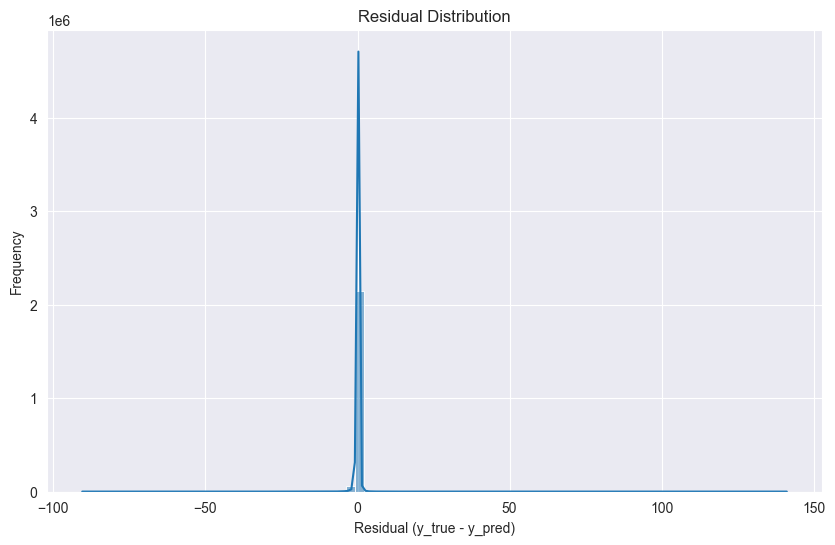

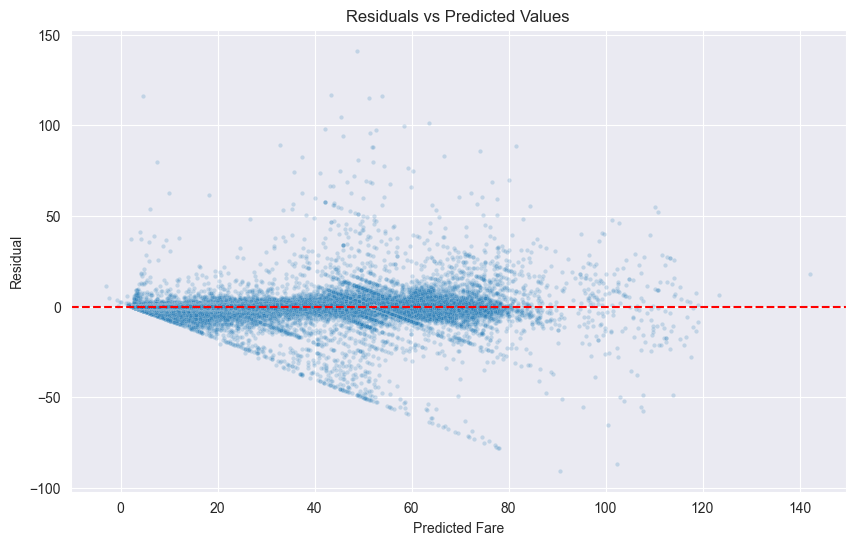

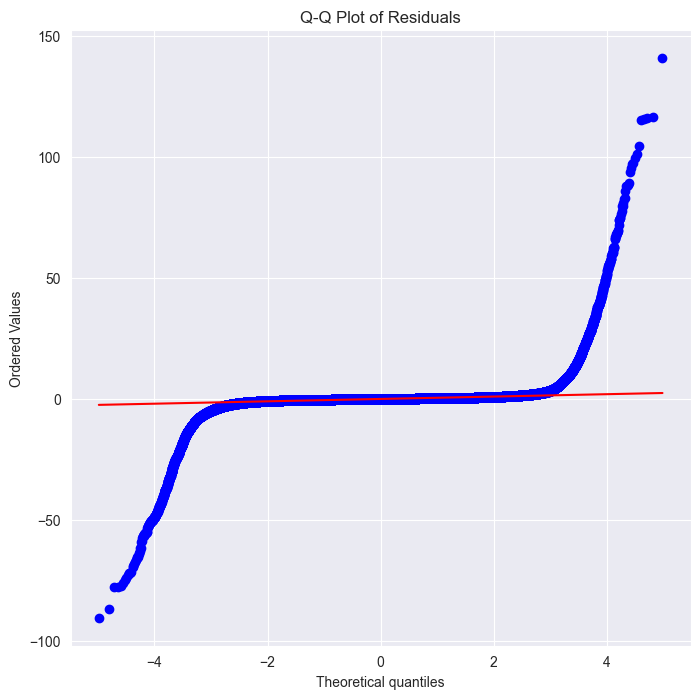

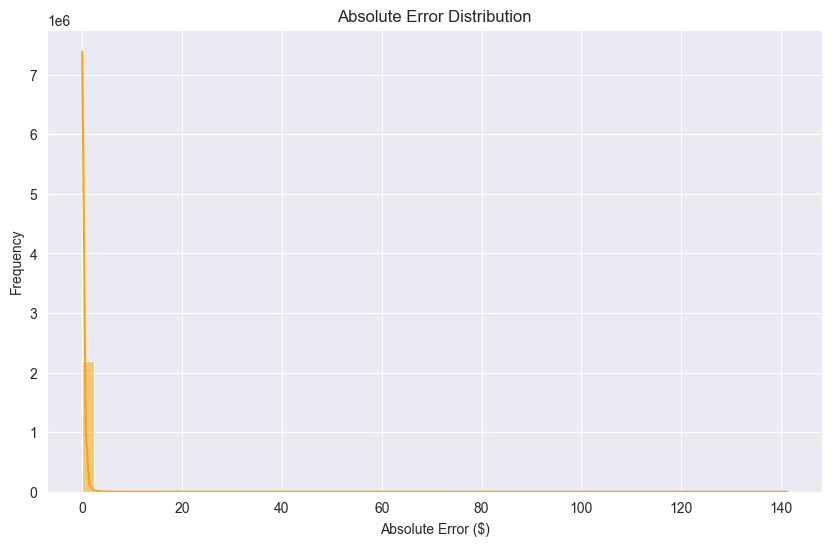

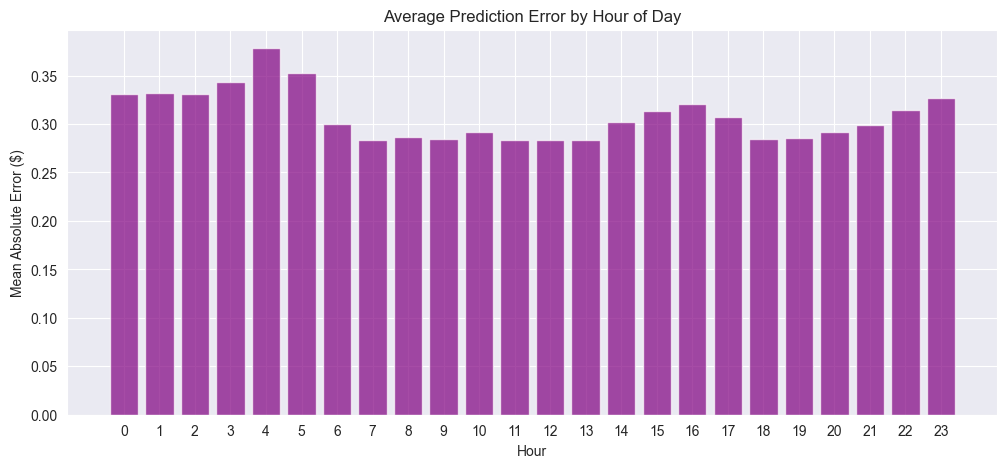

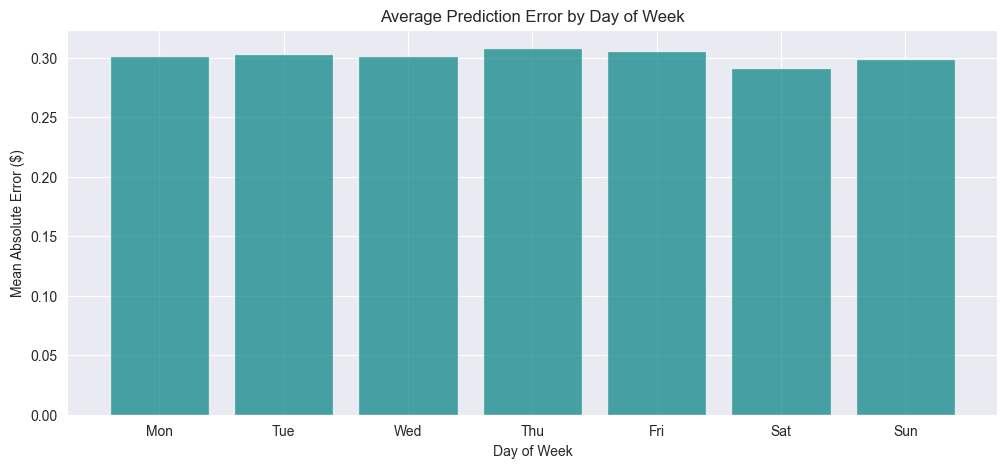


Evaluation complete ✔


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error,
)
import scipy.stats as stats

# -----------------------------------------
# Predictions
# -----------------------------------------
y_pred = cat_model.predict(X_test)

# -----------------------------------------
# Regression metrics
# -----------------------------------------
mse = mean_squared_error(y_test, y_pred)        # MSE
rmse = np.sqrt(mse)                             # RMSE
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# NEW: Mean fare cost (actual mean of ground-truth fares)
mean_fare = y_test.mean()

# Robust alternatives
mape = mean_absolute_percentage_error(y_test, y_pred)
smape = 100 * np.mean(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred)))

mdape = np.median(np.abs((y_test - y_pred) / y_test)) * 100

metrics_df = pd.DataFrame({
    "RMSE": [rmse],
    "MAE": [mae],
    "MSE": [mse],
    "R²": [r2],
    "Mean Fare ($)": [mean_fare],
    "MAPE (%)": [mape * 100],
    "SMAPE (%)": [smape],
    "MdAPE (%)": [mdape],
})

print("=== MODEL PERFORMANCE METRICS ===")
display(metrics_df.round(4))

# -----------------------------------------
# Residuals
# -----------------------------------------
residuals = y_test - y_pred
abs_errors = np.abs(residuals)

# -----------------------------------------
# Plot 1: Residual distribution
# -----------------------------------------
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=80, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual (y_true - y_pred)")
plt.ylabel("Frequency")
plt.show()

# -----------------------------------------
# Plot 2: Residuals vs Predicted
# -----------------------------------------
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.2, s=10)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Fare")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted Values")
plt.show()

# -----------------------------------------
# Plot 3: Q-Q plot
# -----------------------------------------
plt.figure(figsize=(8, 8))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# -----------------------------------------
# Plot 4: Absolute error distribution
# -----------------------------------------
plt.figure(figsize=(10, 6))
sns.histplot(abs_errors, bins=60, kde=True, color="orange")
plt.title("Absolute Error Distribution")
plt.xlabel("Absolute Error ($)")
plt.ylabel("Frequency")
plt.show()

# -----------------------------------------
# Plot 5: Error vs Hour of Day
# -----------------------------------------
test_df = X_test.copy()
test_df["fare_true"] = y_test
test_df["fare_pred"] = y_pred
test_df["abs_error"] = np.abs(test_df["fare_true"] - test_df["fare_pred"])

hourly_error = test_df.groupby("pickup_hour")["abs_error"].mean()

plt.figure(figsize=(12, 5))
plt.bar(hourly_error.index, hourly_error.values, alpha=0.7, color="purple")
plt.title("Average Prediction Error by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Mean Absolute Error ($)")
plt.xticks(range(24))
plt.show()

# -----------------------------------------
# Plot 6: Error vs Day of Week
# -----------------------------------------
dow_error = test_df.groupby("pickup_dayofweek")["abs_error"].mean()
daynames = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

plt.figure(figsize=(12, 5))
plt.bar(range(7), dow_error.values, alpha=0.7, color="teal")
plt.title("Average Prediction Error by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Mean Absolute Error ($)")
plt.xticks(range(7), daynames)
plt.show()

print("\nEvaluation complete ✔")


In [47]:
# =========================================
# Save Trained CatBoost Model
# =========================================

# Path where the model will be saved
model_path = "/Users/I750420/Desktop/Data Science/project_capstone_CatBoost/catboost_fare_model.cbm"

# Save the trained model
cat_model.save_model(model_path)

print(f"Model successfully saved to: {model_path}")


Model successfully saved to: /Users/I750420/Desktop/Data Science/project_capstone_CatBoost/catboost_fare_model.cbm
